<a href="https://colab.research.google.com/github/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo4/animaciones/Red_convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **MÓDULO 4: FUNDAMENTOS DE VISIÓN POR COMPUTADOR**

## Descripción:
Estudio de los principios básicos de captura de imágenes y video, manejo de cámaras (RGB y por termografía) y redes neuronales convolucionales.

### **Profesor - Sesión 7:** Juan Bernardo Gómez Mendoza
### **Monitores - Sesión 7:** Juan Camilo Lugo Rojas y Lucas Miguel Iturriago Salas

#### Configuración del entorno

In [17]:
# @title
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Define parameters
img_size = 34
num_samples_per_class = 1000
total_samples = 2 * num_samples_per_class  # 100 squares + 100 triangles

# Labels in one-hot encoding: [1, 0] for square, [0, 1] for triangle
labels = np.array([[1, 0]] * num_samples_per_class + [[0, 1]] * num_samples_per_class)

# Función para generar imagen de un cuadrado con posición, inclinación y variación de tamaño aleatoria
def generate_square_image():
    # Imagen en blanco
    image = np.ones((img_size, img_size), dtype=np.uint8) * 255
    angle = np.random.uniform(-15, 15)  # Ángulo de rotación aleatorio
    size_variation = np.random.uniform(0.8, 1.2)  # Variación de tamaño
    square_size = int(10 * size_variation)

    # Crear cuadrado en blanco y rotarlo
    square = np.ones((square_size, square_size), dtype=np.uint8) * 255
    cv2.rectangle(square, (0, 0), (square_size - 1, square_size - 1), 0, -1)  # Cuadrado negro sobre fondo blanco

    # Rotación sin bordes negros
    rotation_matrix = cv2.getRotationMatrix2D((square_size // 2, square_size // 2), angle, 1.0)
    rotated_square = cv2.warpAffine(square, rotation_matrix, (square_size, square_size), borderValue=255)

    # Colocar el cuadrado rotado en una posición aleatoria dentro de la imagen
    x_offset = np.random.randint(0, img_size - square_size)
    y_offset = np.random.randint(0, img_size - square_size)
    image[y_offset:y_offset + square_size, x_offset:x_offset + square_size] = rotated_square
    return image

# Función para generar imagen de un triángulo con posición e inclinación aleatoria
def generate_triangle_image():
    # Imagen en blanco
    image = np.ones((img_size, img_size), dtype=np.uint8) * 255
    angle = np.random.uniform(-15, 15)
    triangle_height = np.random.randint(10, 15)
    triangle_width = np.random.randint(10, 15)

    # Puntos para el triángulo
    triangle_cnt = np.array([
        [(triangle_width // 2, 0)],
        [(0, triangle_height)],
        [(triangle_width, triangle_height)]
    ])

    # Crear el triángulo en blanco y rotarlo
    mask = np.ones((triangle_height, triangle_width), dtype=np.uint8) * 255
    cv2.drawContours(mask, [triangle_cnt], 0, 0, -1)
    rotation_matrix = cv2.getRotationMatrix2D((triangle_width // 2, triangle_height // 2), angle, 1.0)
    rotated_triangle = cv2.warpAffine(mask, rotation_matrix, (triangle_width, triangle_height), borderValue=255)

    # Colocar el triángulo rotado en una posición aleatoria dentro de la imagen
    x_offset = np.random.randint(0, img_size - triangle_width)
    y_offset = np.random.randint(0, img_size - triangle_height)
    image[y_offset:y_offset + triangle_height, x_offset:x_offset + triangle_width] = rotated_triangle
    return image

### **Objetivo**

Construir variaciones de una red convolucional para clasificación de figuras y entrenalar para analizar su rendimiento en el entrenamiento y el desempeño sobre los datos de evaluación

### **Datos**

Se generan cuadrados y triangulos con traslación y rotación para crear una base de datos de 2000 imágenes en blanco y negro de 34x34, particionada en datos para entrenar, validar y evaluar

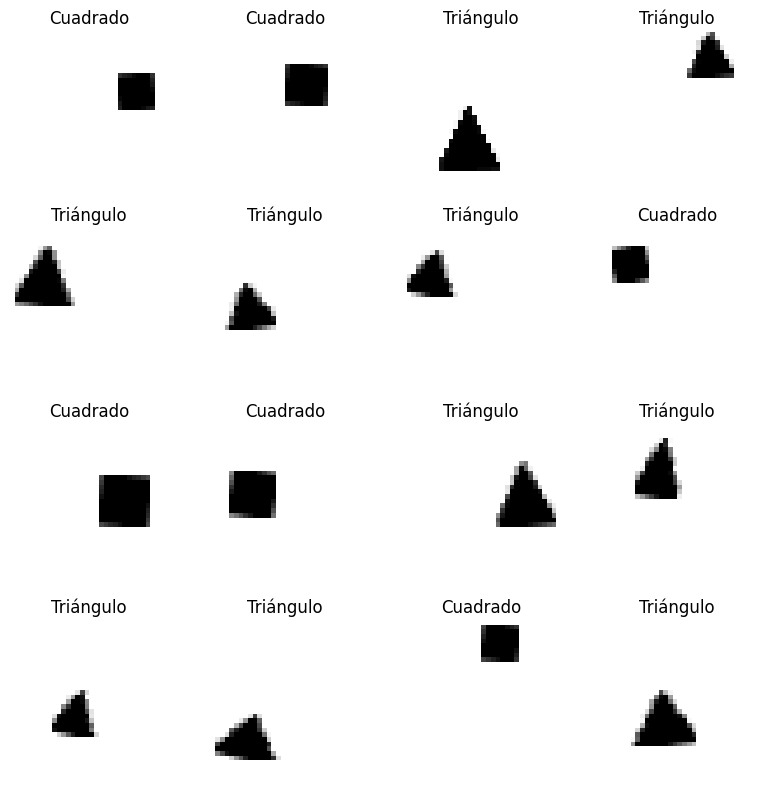

In [18]:
# @title
# Generate dataset
images = np.array([generate_square_image() for _ in range(num_samples_per_class)] +
                  [generate_triangle_image() for _ in range(num_samples_per_class)])

# Shuffle the dataset
indices = np.arange(total_samples)
np.random.shuffle(indices)
images, labels = images[indices], labels[indices]

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Definir el número de filas y columnas para la cuadrícula de imágenes
num_rows, num_cols = 4, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Mostrar algunas imágenes de entrenamiento con sus etiquetas
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')  # Asumiendo que las imágenes están en escala de grises
    label = 'Cuadrado' if y_train[i][0] == 1 else 'Triángulo'  # Decodificar etiqueta
    ax.set_title(label)
    ax.axis('off')  # Ocultar los ejes

plt.tight_layout()
plt.show()

# Reshape data for convolutional network input and normalize
X_train = X_train.reshape(-1, img_size, img_size, 1) / 255.0
X_val = X_val.reshape(-1, img_size, img_size, 1) / 255.0
X_test = X_test.reshape(-1, img_size, img_size, 1) / 255.0

### **Definición modelo 1 y su entrenamiento**

Se define un modelo con la siguiente arquitectura:
*   Capa convolucional con pesos fijos y filtro Sobel horizontal
*   Capa de Max Pooling
*   Capa convolucional con pesos fijos y filtro Sobel vertical
*   Capa de Max Pooling
*   Capa de aplanado
*   Capa densa de 8 neuronas y función de activación Lineal
*   Capa densa con función de activación Softmax


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3968 - loss: 2.2791 - val_accuracy: 0.4100 - val_loss: 1.5445
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3986 - loss: 1.4345 - val_accuracy: 0.4125 - val_loss: 1.1210
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4721 - loss: 0.9898 - val_accuracy: 0.4725 - val_loss: 0.8982
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5400 - loss: 0.7998 - val_accuracy: 0.5300 - val_loss: 0.7718
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5992 - loss: 0.7073 - val_accuracy: 0.6150 - val_loss: 0.6787
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6762 - loss: 0.6266 - val_accuracy: 0.6600 - val_loss: 0.6256
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7344 - loss: 0.5640 - val_accuracy: 0.7025 - val_loss: 0.5859
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7508 - loss: 0.5347 - val_accuracy: 0.7300 - val_loss: 0.5492
Epo

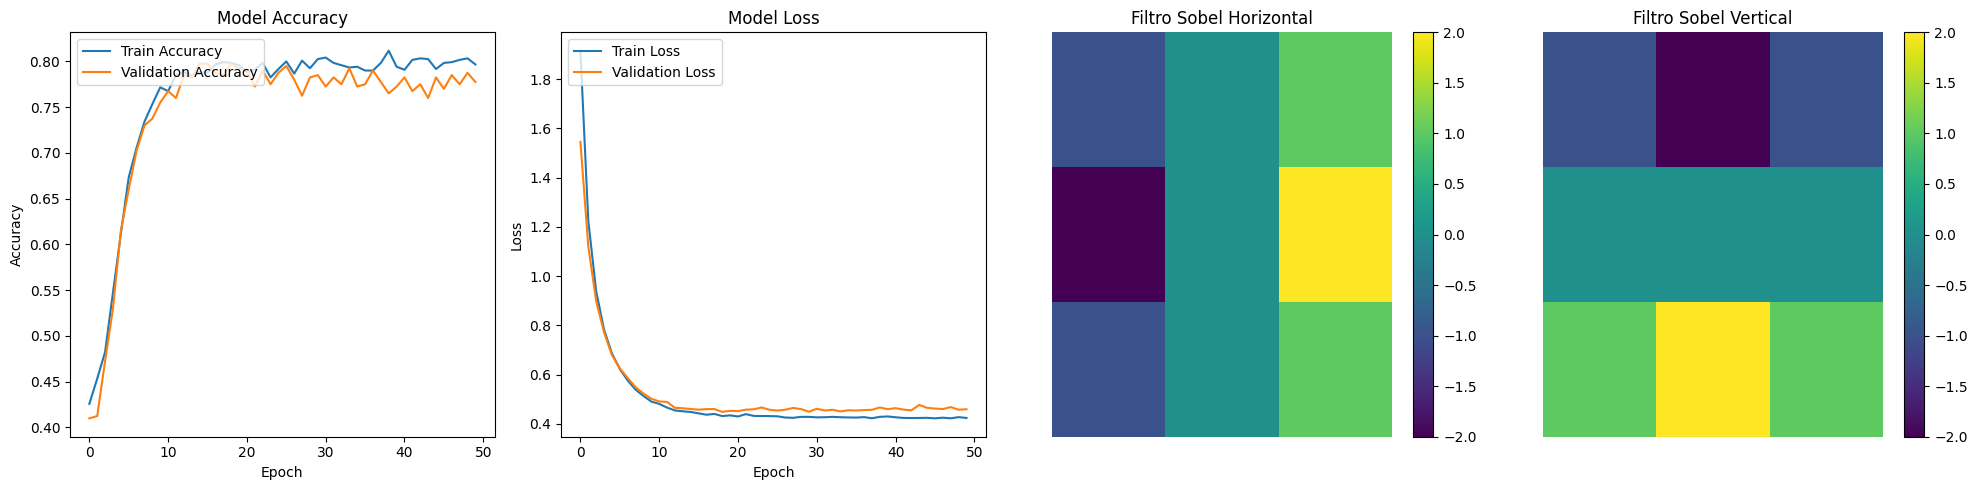

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


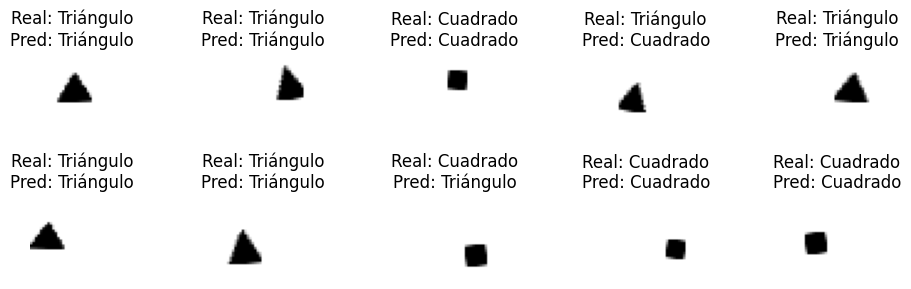

In [19]:
# @title
# Se definen los filtros Sobel
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32).reshape((3, 3, 1, 1))
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32).reshape((3, 3, 1, 1))

# Construccion del modelo convolucional 1
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), padding="same", input_shape=(img_size, img_size, 1),
                           kernel_initializer=tf.constant_initializer(sobel_horizontal), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), padding="same",
                           kernel_initializer=tf.constant_initializer(sobel_vertical), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="linear"),
    tf.keras.layers.Dense(2, activation="softmax")
])

# Se compila el modelo 1
model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Se entrena el modelo 1
history = model_1.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

# Extraer los pesos de la primera capa convolucional
layer_weights_1 = model_1.layers[0].get_weights()[0][:, :, 0, 0]  # Obtener filtro 3x3
layer_weights_2 = model_1.layers[2].get_weights()[0][:, :, 0, 0]  # Segundo filtro 3x3

# Crear una figura con 1 fila y 4 columnas
plt.figure(figsize=(20, 5))

# Gráfico de precisión
plt.subplot(1, 4, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# Gráfico de pérdida
plt.subplot(1, 4, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Mapa de calor del primer filtro (Sobel horizontal)
plt.subplot(1, 4, 3)
plt.imshow(layer_weights_1, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Horizontal")
plt.colorbar()
plt.axis("off")

# Mapa de calor del segundo filtro (Sobel vertical)
plt.subplot(1, 4, 4)
plt.imshow(layer_weights_2, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Vertical")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# Realiza predicciones en el conjunto de prueba
predictions = model_1.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Diccionario de nombres de clases
class_names = ["Cuadrado", "Triángulo"]

# Muestra algunas imágenes junto con las clases reales y predichas
num_images = 10
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap="gray")
    plt.title(f"Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Definición modelo 2 y su entrenamiento**

Se define un modelo con la siguiente arquitectura:
*   Capa convolucional con pesos fijos y filtro Sobel horizontal
*   Capa de Max Pooling
*   Capa convolucional con pesos fijos y filtro Sobel vertical
*   Capa de Max Pooling
*   Capa de aplanado
*   Capa densa de 8 neuronas
*   Capa densa con función de activación Softmax


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4729 - loss: 1.3482 - val_accuracy: 0.4950 - val_loss: 0.9229
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5153 - loss: 0.8820 - val_accuracy: 0.5350 - val_loss: 0.7698
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5708 - loss: 0.7642 - val_accuracy: 0.5850 - val_loss: 0.6846
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6079 - loss: 0.6808 - val_accuracy: 0.6450 - val_loss: 0.6230
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6863 - loss: 0.5885 - val_accuracy: 0.6850 - val_loss: 0.5828
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7507 - loss: 0.5468 - val_accuracy: 0.7150 - val_loss: 0.5534
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7721 - loss: 0.4935 - val_accuracy: 0.7425 - val_loss: 0.5294
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7696 - loss: 0.4849 - val_accuracy: 0.7825 - val_loss

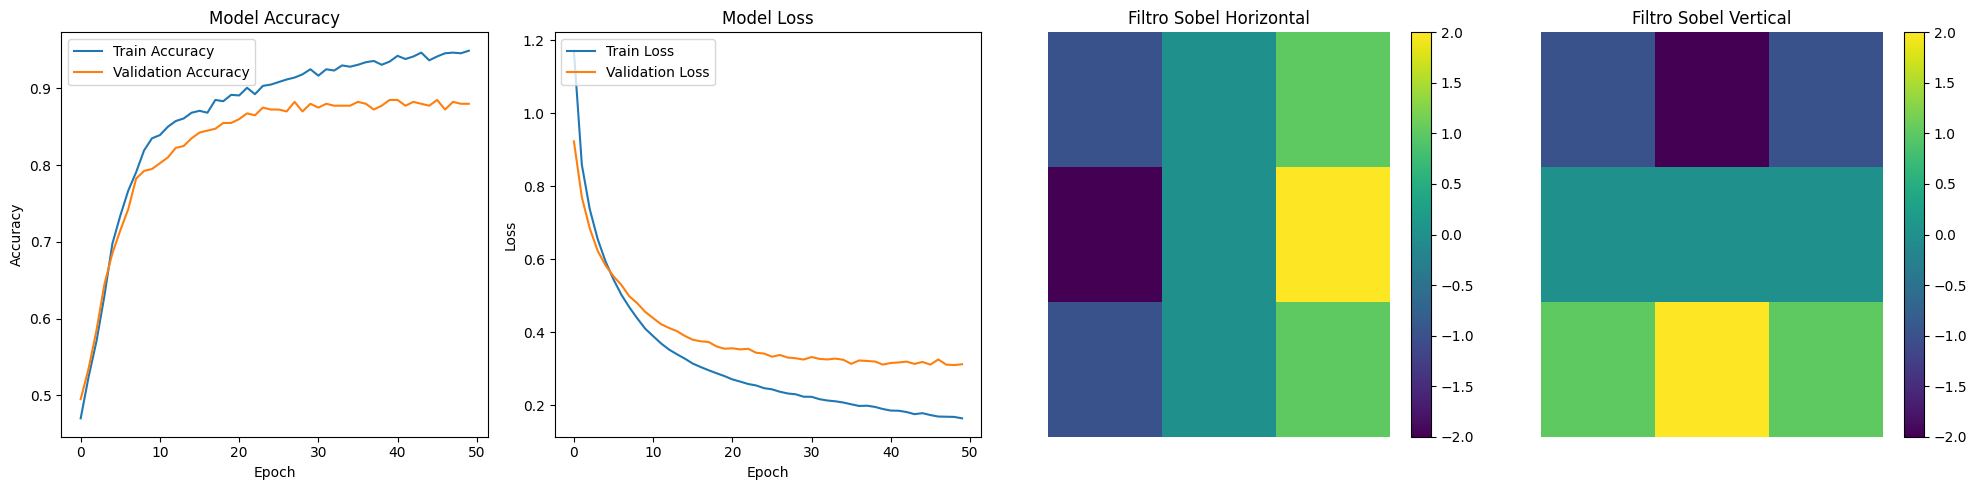

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


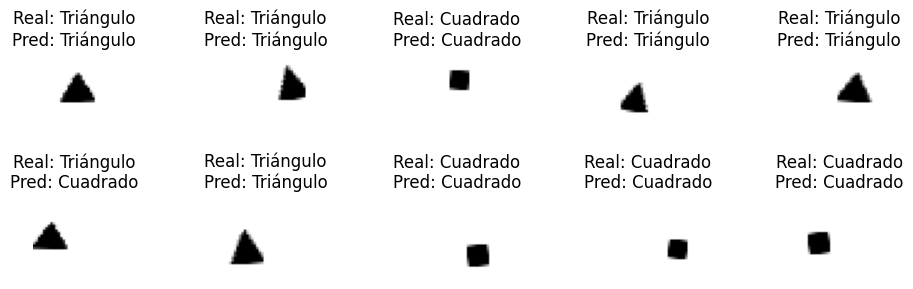

In [20]:
# @title
# Se definen los filtros Sobel
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32).reshape((3, 3, 1, 1))
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32).reshape((3, 3, 1, 1))

# Construccion del modelo convolucional 2
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), padding="same", input_shape=(img_size, img_size, 1),
                           kernel_initializer=tf.constant_initializer(sobel_horizontal), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), padding="same",
                           kernel_initializer=tf.constant_initializer(sobel_vertical), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

# Se compila el modelo 2
model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Se entrena el modelo 2
history = model_2.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

# Extraer los pesos de la primera capa convolucional
layer_weights_1 = model_2.layers[0].get_weights()[0][:, :, 0, 0]  # Obtener filtro 3x3
layer_weights_2 = model_2.layers[2].get_weights()[0][:, :, 0, 0]  # Segundo filtro 3x3

# Crear una figura con 1 fila y 4 columnas
plt.figure(figsize=(20, 5))

# Gráfico de precisión
plt.subplot(1, 4, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# Gráfico de pérdida
plt.subplot(1, 4, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Mapa de calor del primer filtro (Sobel horizontal)
plt.subplot(1, 4, 3)
plt.imshow(layer_weights_1, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Horizontal")
plt.colorbar()
plt.axis("off")

# Mapa de calor del segundo filtro (Sobel vertical)
plt.subplot(1, 4, 4)
plt.imshow(layer_weights_2, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Vertical")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# Realiza predicciones en el conjunto de prueba
predictions = model_2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Diccionario de nombres de clases
class_names = ["Cuadrado", "Triángulo"]

# Muestra algunas imágenes junto con las clases reales y predichas
num_images = 10
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap="gray")
    plt.title(f"Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Definición modelo 3 y su entrenamiento**

Se define un modelo con la siguiente arquitectura:
*   Capa convolucional con filtro Sobel horizontal entrenable
*   Capa de Max Pooling
*   Capa convolucional con filtro Sobel vertical entrenable
*   Capa de Max Pooling
*   Capa de aplanado
*   Capa densa de 8 neuronas
*   Capa densa con función de activación Softmax


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5472 - loss: 1.2044 - val_accuracy: 0.5725 - val_loss: 0.7823
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5524 - loss: 0.7730 - val_accuracy: 0.6325 - val_loss: 0.6494
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6642 - loss: 0.6299 - val_accuracy: 0.7125 - val_loss: 0.5830
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6927 - loss: 0.5806 - val_accuracy: 0.7525 - val_loss: 0.5379
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7216 - loss: 0.5514 - val_accuracy: 0.7525 - val_loss: 0.5087
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7748 - loss: 0.4973 - val_accuracy: 0.7750 - val_loss: 0.4737
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8073 - loss: 0.4393 - val_accuracy: 0.7950 - val_loss: 0.4420
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8273 - loss: 0.4264 - val_accuracy: 0.7900 - val_loss: 0.4245

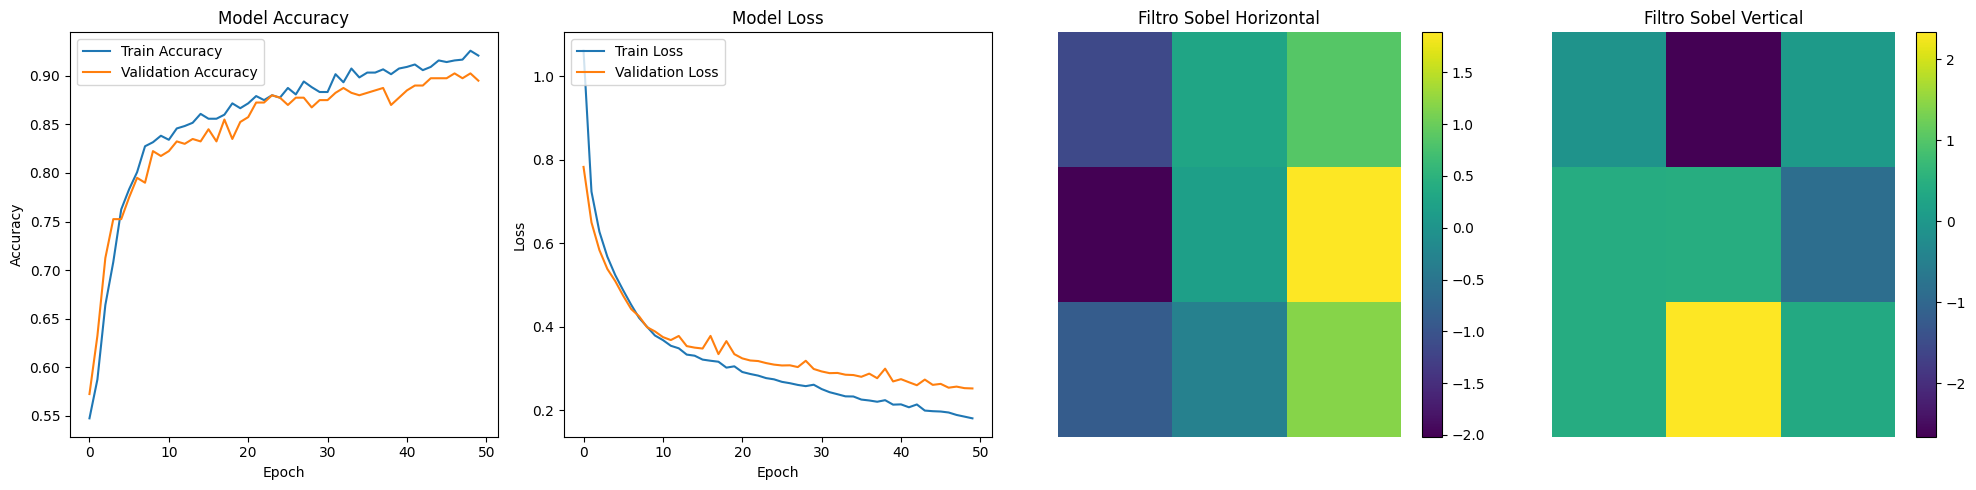

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


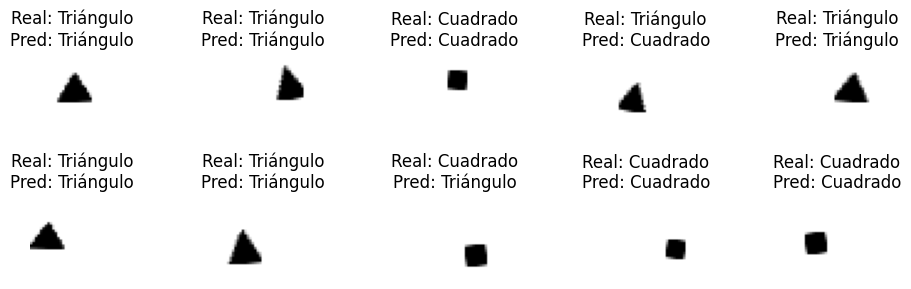

In [23]:
# @title
# Se definen los filtros Sobel
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32).reshape((3, 3, 1, 1))
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32).reshape((3, 3, 1, 1))

# Construccion del modelo convolucional 3
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), padding="same", input_shape=(img_size, img_size, 1),
                           kernel_initializer=tf.constant_initializer(sobel_horizontal), trainable=True),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), padding="same",
                           kernel_initializer=tf.constant_initializer(sobel_vertical), trainable=True),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(2, activation="softmax")
])

# Se compila el modelo 3
model_3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Se entrena el modelo 3
history = model_3.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

# Extraer los pesos de la primera capa convolucional
layer_weights_1 = model_3.layers[0].get_weights()[0][:, :, 0, 0]  # Obtener filtro 3x3
layer_weights_2 = model_3.layers[2].get_weights()[0][:, :, 0, 0]  # Segundo filtro 3x3

# Crear una figura con 1 fila y 4 columnas
plt.figure(figsize=(20, 5))

# Gráfico de precisión
plt.subplot(1, 4, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# Gráfico de pérdida
plt.subplot(1, 4, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Mapa de calor del primer filtro (Sobel horizontal)
plt.subplot(1, 4, 3)
plt.imshow(layer_weights_1, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Horizontal")
plt.colorbar()
plt.axis("off")

# Mapa de calor del segundo filtro (Sobel vertical)
plt.subplot(1, 4, 4)
plt.imshow(layer_weights_2, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Vertical")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# Realiza predicciones en el conjunto de prueba
predictions = model_3.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Diccionario de nombres de clases
class_names = ["Cuadrado", "Triángulo"]

# Muestra algunas imágenes junto con las clases reales y predichas
num_images = 10
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap="gray")
    plt.title(f"Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Definición modelo 4 y su entrenamiento**

Se define un modelo con la siguiente arquitectura:
*   Capa convolucional con pesos filtros y filtro Sobel horizontal
*   Capa de Max Pooling
*   Capa convolucional con pesos filtros y filtro Sobel vertical entrenable
*   Capa de Max Pooling
*   Capa de aplanado
*   Capa densa de 16 neuronas
*   Capa densa con función de activación Softmax


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4641 - loss: 2.0617 - val_accuracy: 0.5225 - val_loss: 1.0576
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5107 - loss: 0.9823 - val_accuracy: 0.5650 - val_loss: 0.8443
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5878 - loss: 0.7629 - val_accuracy: 0.6200 - val_loss: 0.7188
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6468 - loss: 0.6591 - val_accuracy: 0.6875 - val_loss: 0.6331
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6858 - loss: 0.5972 - val_accuracy: 0.7075 - val_loss: 0.5793
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7412 - loss: 0.5273 - val_accuracy: 0.7400 - val_loss: 0.5391
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7729 - loss: 0.4895 - val_accuracy: 0.7475 - val_loss: 0.5108
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7566 - loss: 0.5035 - val_accuracy: 0.7525 - val_los

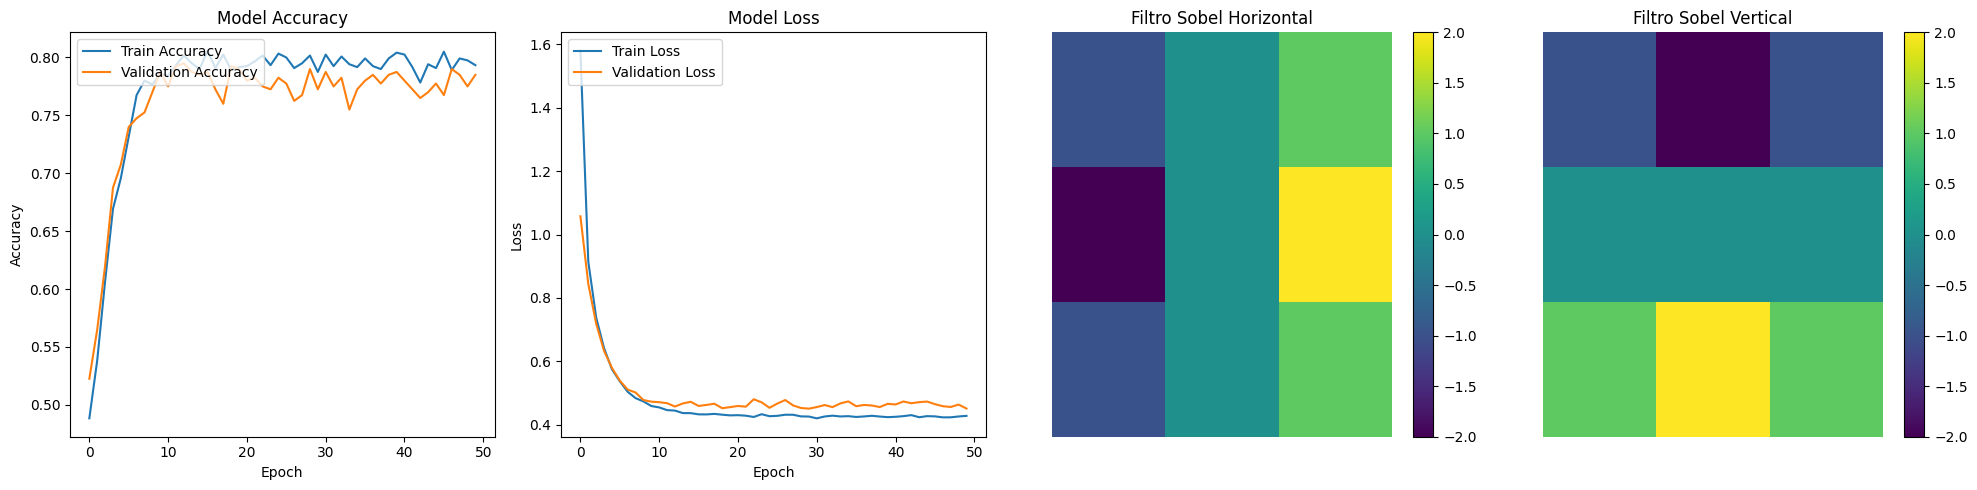

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


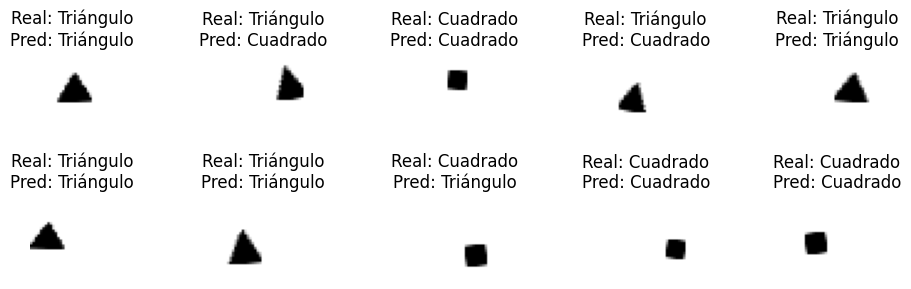

In [24]:
# @title
# Se definen los filtros Sobel
sobel_horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32).reshape((3, 3, 1, 1))
sobel_vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32).reshape((3, 3, 1, 1))

# Construccion del modelo convolucional 3
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (3, 3), padding="same", input_shape=(img_size, img_size, 1),
                           kernel_initializer=tf.constant_initializer(sobel_horizontal), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(1, (3, 3), padding="same",
                           kernel_initializer=tf.constant_initializer(sobel_vertical), trainable=False),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(2, activation="softmax")
])

# Se compila el modelo 4
model_4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Se entrena el modelo 4
history = model_4.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

# Extraer los pesos de la primera capa convolucional
layer_weights_1 = model_4.layers[0].get_weights()[0][:, :, 0, 0]  # Obtener filtro 3x3
layer_weights_2 = model_4.layers[2].get_weights()[0][:, :, 0, 0]  # Segundo filtro 3x3

# Crear una figura con 1 fila y 4 columnas
plt.figure(figsize=(20, 5))

# Gráfico de precisión
plt.subplot(1, 4, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

# Gráfico de pérdida
plt.subplot(1, 4, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")

# Mapa de calor del primer filtro (Sobel horizontal)
plt.subplot(1, 4, 3)
plt.imshow(layer_weights_1, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Horizontal")
plt.colorbar()
plt.axis("off")

# Mapa de calor del segundo filtro (Sobel vertical)
plt.subplot(1, 4, 4)
plt.imshow(layer_weights_2, cmap="viridis", aspect="auto")
plt.title("Filtro Sobel Vertical")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

# Realiza predicciones en el conjunto de prueba
predictions = model_4.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Diccionario de nombres de clases
class_names = ["Cuadrado", "Triángulo"]

# Muestra algunas imágenes junto con las clases reales y predichas
num_images = 10
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(img_size, img_size), cmap="gray")
    plt.title(f"Real: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()